## 第8章　CAEを使ったノイズ除去

**共通モジュールの読み込み**

In [1]:
import os
import glob
import math
import random

import numpy as np
import matplotlib.pyplot as plt
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.models import Model, Sequential
from tensorflow.python.keras.preprocessing.image import load_img, img_to_array, array_to_img
from tensorflow.python.keras.layers import Conv2D, Dense, Input, MaxPooling2D, UpSampling2D, Lambda

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


**リスト8.1:CIFAR10データセットの読み込みと前処理**

In [2]:
from tensorflow.python.keras.datasets import cifar10

(x_train, _), (x_test, _) = cifar10.load_data() 
# 画像を0-1の範囲に正規化
x_train = x_train/255.  #  (50000, 32, 32, 3)
x_test = x_test/255.  # (10000, 32, 32, 3)

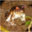

In [3]:
array_to_img(x_train[0])

**リスト8.2:マスキングノイズを加えて、擬似ノイズデータを生成**

In [4]:
def make_masking_noise_data(data_x, percent=0.1):
    size = data_x.shape
    masking = np.random.binomial(n=1, p=percent, size=size) # 二項分布（互いに独立したベルヌーイ試行を n 回行ったときにある事象が何回起こるかの確率分布）によるノイズ
    return data_x*masking

x_train_masked = make_masking_noise_data(x_train)
x_test_masked = make_masking_noise_data(x_test)

**リスト8.3:ガウシアンノイズを加えて、擬似ノイズデータを生成**

In [5]:
def make_gaussian_noise_data(data_x, scale=0.8):
    gaussian_data_x = data_x + np.random.normal(loc=0, scale=scale, size=data_x.shape)
    gaussian_data_x = np.clip(gaussian_data_x, 0, 1)
    return gaussian_data_x

x_train_gauss = make_gaussian_noise_data(x_train)
x_test_gauss = make_gaussian_noise_data(x_test)

**リスト8.4:ノイズを加えた画像とオリジナル画像との比較**

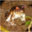

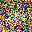

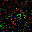

In [6]:
from IPython.display import display_png


display_png(array_to_img(x_train[0]))
display_png(array_to_img(x_train_gauss[0]))
display_png(array_to_img(x_train_masked[0]))

**リスト8.5:CAEモデルの構築**

In [7]:
# Sigmoid + Binary cross entropy
autoencoder = Sequential()

# Encoder箇所
autoencoder.add(
    Conv2D(
        16,
        (3, 3),
        1,
        activation='relu', 
        padding='same', 
        input_shape=(32, 32, 3)
    )
)
autoencoder.add(
    MaxPooling2D(
        (2, 2),
        padding='same'
    )
)
autoencoder.add(
    Conv2D(
        8,
        (3, 3),
        1,
        activation='relu', 
        padding='same'
    )
)
autoencoder.add(
    MaxPooling2D(
        (2, 2),
        padding='same'
    )
)

# Decoder箇所
autoencoder.add(
    Conv2D(
        8,
        (3, 3),
        1,
        activation='relu', 
        padding='same'
    )
)
autoencoder.add(UpSampling2D((2, 2)))
autoencoder.add(
    Conv2D(
        16,
        (3, 3),
        1,
        activation='relu', 
        padding='same'
    )
)
autoencoder.add(UpSampling2D((2, 2)))
autoencoder.add(
    Conv2D(
        3,
        (3, 3),
        1,
        activation='sigmoid', # sigmoid 
        padding='same'
    )
)

autoencoder.compile(
    optimizer='adam', 
    loss='binary_crossentropy'
) 
initial_weights = autoencoder.get_weights()

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [7]:
# Mean Squared Error
autoencoder = Sequential()

# Encoder箇所
autoencoder.add(
    Conv2D(
        16,
        (3, 3),
        1,
        activation='relu', 
        padding='same', 
        input_shape=(32, 32, 3)
    )
)
autoencoder.add(
    MaxPooling2D(
        (2, 2),
        padding='same'
    )
)
autoencoder.add(
    Conv2D(
        8,
        (3, 3),
        1,
        activation='relu', 
        padding='same'
    )
)
autoencoder.add(
    MaxPooling2D(
        (2, 2),
        padding='same'
    )
)

# Decoder箇所
autoencoder.add(
    Conv2D(
        8,
        (3, 3),
        1,
        activation='relu', 
        padding='same'
    )
)
autoencoder.add(UpSampling2D((2, 2)))
autoencoder.add(
    Conv2D(
        16,
        (3, 3),
        1,
        activation='relu', 
        padding='same'
    )
)
autoencoder.add(UpSampling2D((2, 2)))
autoencoder.add(
    Conv2D(
        3,
        (3, 3),
        1,
        padding='same'
    )
)

autoencoder.compile(
    optimizer='adam', 
    loss='mse'
) 
initial_weights = autoencoder.get_weights()

Instructions for updating:
keep_dims is deprecated, use keepdims instead


**リスト8.6 モデルのサマリを確認**

In [8]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 16)        448       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 8)         1160      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 8)           0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 8)           584       
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 16, 16, 8)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 16)        1168      
__________

**リスト8.7:ガウシアンノイズを用いて学習**

In [9]:
autoencoder.fit(
                x_train_gauss, # 入力：ガウシアンノイズデータ
                x_train,       # 正解：オリジナル画像
                epochs=20,     # 学習するエポック回数
                batch_size=20, # バッチサイズ
                shuffle=True   # シャッフルデータにする
               )

Epoch 1/20
50000/50000 [==============================]50000/50000 [==============================] - 23s 460us/step - loss: 0.0228

Epoch 2/20
50000/50000 [==============================]50000/50000 [==============================] - 22s 450us/step - loss: 0.0184

Epoch 3/20
50000/50000 [==============================]50000/50000 [==============================] - 22s 446us/step - loss: 0.0179

Epoch 4/20
50000/50000 [==============================]50000/50000 [==============================] - 22s 444us/step - loss: 0.0175

Epoch 5/20
50000/50000 [==============================]50000/50000 [==============================] - 22s 449us/step - loss: 0.0173

Epoch 6/20
50000/50000 [==============================]50000/50000 [==============================] - 22s 446us/step - loss: 0.0171

Epoch 7/20
50000/50000 [==============================]50000/50000 [==============================] - 22s 445us/step - loss: 0.0170

Epoch 8/20
50000/50000 [==============================]50000/50000 [=

**リスト8.8:ガウシアンノイズで学習したモデルでの予測**

In [10]:
gauss_preds = autoencoder.predict(x_test_gauss)

**リスト8.9:ガウシアンノイズ画像、CAEモデル、オリジナル画像の予測の比較**

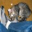

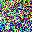

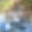

-------------------------


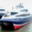

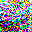

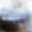

-------------------------


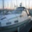

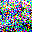

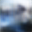

-------------------------


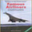

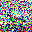

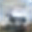

-------------------------


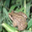

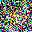

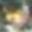

-------------------------


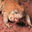

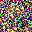

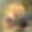

-------------------------


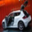

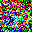

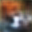

-------------------------


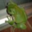

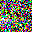

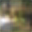

-------------------------


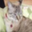

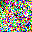

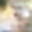

-------------------------


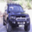

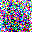

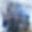

-------------------------


In [11]:
# sigmoid + binary cross entropy
for i in range(10):
    display_png(array_to_img(x_test[i]))
    display_png(array_to_img(x_test_gauss[i]))
    display_png(array_to_img(gauss_preds[i]))
    print('-'*25)

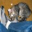

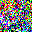

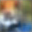

-------------------------


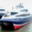

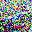

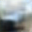

-------------------------


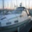

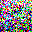

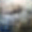

-------------------------


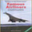

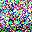

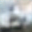

-------------------------


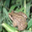

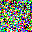

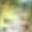

-------------------------


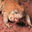

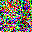

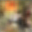

-------------------------


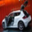

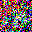

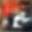

-------------------------


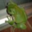

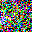

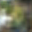

-------------------------


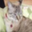

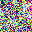

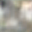

-------------------------


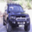

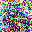

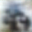

-------------------------


In [11]:
# MSE
for i in range(10):
    display_png(array_to_img(x_test[i]))
    display_png(array_to_img(x_test_gauss[i]))
    display_png(array_to_img(gauss_preds[i]))
    print('-'*25)

**リスト8.10:CAEモデルの重みを初期化**

In [12]:
autoencoder.set_weights(initial_weights)

**リスト8.11:マスキングノイズを用いて学習**

In [13]:
autoencoder.fit(
                x_train_masked, # 入力：マスキングノイズデータ
                x_train,        # 正解：オリジナル画像
                epochs=20,      # 学習するエポック回数
                batch_size=20,  # バッチサイズ
                shuffle=True    # シャッフルデータにする
               )

Epoch 1/20
50000/50000 [==============================]50000/50000 [==============================] - 22s 446us/step - loss: 0.0189

Epoch 2/20
50000/50000 [==============================]50000/50000 [==============================] - 22s 447us/step - loss: 0.0147

Epoch 3/20
50000/50000 [==============================]50000/50000 [==============================] - 22s 445us/step - loss: 0.0134

Epoch 4/20
50000/50000 [==============================]50000/50000 [==============================] - 22s 446us/step - loss: 0.0127

Epoch 5/20
50000/50000 [==============================]50000/50000 [==============================] - 22s 443us/step - loss: 0.0123

Epoch 6/20
50000/50000 [==============================]50000/50000 [==============================] - 22s 443us/step - loss: 0.0121

Epoch 7/20
50000/50000 [==============================]50000/50000 [==============================] - 22s 445us/step - loss: 0.0120

Epoch 8/20
50000/50000 [==============================]50000/50000 [=

**リスト8.12:マスキングノイズデータで学習したモデルでの予測**

In [14]:
masked_preds = autoencoder.predict(x_test_masked)

**リスト8.13:マスキングノイズ画像、CAEモデル、オリジナル画像の予測の比較**

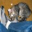

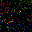

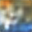

-------------------------


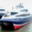

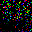

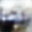

-------------------------


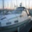

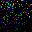

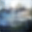

-------------------------


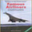

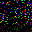

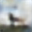

-------------------------


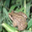

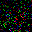

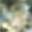

-------------------------


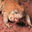

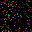

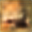

-------------------------


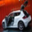

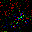

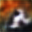

-------------------------


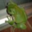

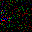

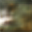

-------------------------


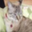

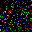

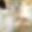

-------------------------


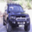

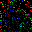

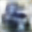

-------------------------


In [15]:
# sigmoid + binary cross entropy
for i in range(10):
    display_png(array_to_img(x_test[i]))
    display_png(array_to_img(x_test_masked[i]))
    display_png(array_to_img(masked_preds[i]))
    print('-'*25)

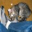

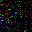

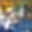

-------------------------


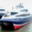

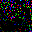

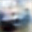

-------------------------


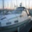

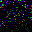

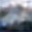

-------------------------


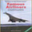

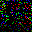

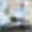

-------------------------


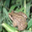

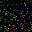

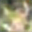

-------------------------


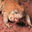

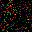

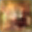

-------------------------


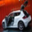

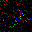

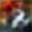

-------------------------


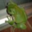

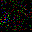

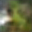

-------------------------


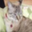

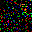

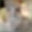

-------------------------


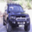

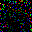

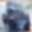

-------------------------


In [15]:
# MSE
for i in range(10):
    display_png(array_to_img(x_test[i]))
    display_png(array_to_img(x_test_masked[i]))
    display_png(array_to_img(masked_preds[i]))
    print('-'*25)

結果
- sigmoid + binary cross entropy の出力のほうが MSE の出力より全体的にモワッとしている（ボケている）
- ただし、2値画像に近い画像については sigmoid + binary cross entropy のほうがややくっきりしている
